<a href="https://colab.research.google.com/github/Riky2014/Tesi/blob/main/1d_hemo_solver_branch_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!apt-get install software-properties-common
!add-apt-repository -y ppa:fenics-packages/fenics
!apt-get update -qq
!apt install fenics

In [ ]:
from fenics import *

import logging
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set the logging level to suppress FFC messages
set_log_level(LogLevel.ERROR)
logging.getLogger('FFC').setLevel(logging.ERROR)
logging.getLogger('UFL_LEGACY').setLevel(logging.WARNING)

# Dictionaries containing network information

In [ ]:
# Define branches
branches = {
    'branch_1': {
        'L': 2,
        'A0': 1.086,
        'beta': 0.060816e7,
        'boundary': {
            'start': {'type': 'inlet', 'connected_to': [], 'alpha':[]},
            'end': {'type': 'branch', 'connected_to': ['branch_2', 'branch_3'], 'alpha': []}
        }
    },
    'branch_2': {
        'L': 1,
        'A0': 0.126,
        'beta': 0.060606e7,
        'boundary': {
            'start': {'type': 'branch', 'connected_to': ['branch_1'], 'alpha':[pi / 3]},
            'end': {'type': 'branch', 'connected_to': ['branch_4', 'branch_5'], 'alpha':[]}
        }
    },
    'branch_3': {
        'L': 6.6,
        'A0': 0.659,
        'beta': 0.046130e7,
        'boundary': {
            'start': {'type': 'branch', 'connected_to': ['branch_1'], 'alpha':[pi / 4]},
            'end': {'type': 'outlet', 'connected_to': [], 'alpha':[]}
        }
    },
    'branch_4': {
        'L': 7.11,
        'A0': 0.442,
        'beta': 0.042432e7,
        'boundary': {
            'start': {'type': 'branch', 'connected_to': ['branch_2'], 'alpha':[pi / 4]},
            'end': {'type': 'outlet', 'connected_to': [], 'alpha':[]}
        }
    },
    'branch_5': {
        'L': 6.3,
        'A0': 0.468,
        'beta': 0.051012e7,
        'boundary': {
            'start': {'type': 'branch', 'connected_to': ['branch_2'], 'alpha':[pi / 4]},
            'end': {'type': 'outlet', 'connected_to': [], 'alpha':[]}
        }
    }
}

In [ ]:
# Print network information
print("\nNetwork Information:")
num_branches = len(branches)
print(f"Number of branches: {num_branches}")

print("\nBranch Connectivity:")
for branch_name, branch_data in branches.items():
    start_connections = branch_data['boundary']['start']['connected_to']
    end_connections = branch_data['boundary']['end']['connected_to']
    print(f"{branch_name}:")
    print(f"  Start connected to: {start_connections}")
    print(f"  End connected to: {end_connections}")


Network Information:
Number of branches: 5

Branch Connectivity:
branch_1:
  Start connected to: []
  End connected to: ['branch_2', 'branch_3']
branch_2:
  Start connected to: ['branch_1']
  End connected to: ['branch_4', 'branch_5']
branch_3:
  Start connected to: ['branch_1']
  End connected to: []
branch_4:
  Start connected to: ['branch_2']
  End connected to: []
branch_5:
  Start connected to: ['branch_2']
  End connected to: []


# Global Data

In [ ]:
# Global data
T = 1

# gamma_1 = 0 # see https://www.researchgate.net/publication/37445437_One-dimensional_models_for_blood_flow_in_arteries pag 12 for reference values
# gamma_2 = 2
# gamma_3 = 2

alpha = 1
k_r = 2.419
rho = 1.050

# Discretization parameter

In [ ]:
# Given values
dt = 2e-5
N_T = round(T / dt)

h = 1 / 32

print(f'h = {h}')
print(f'dt = {dt}')
print(f'CFL ratio : {h / dt}')

h = 0.03125
dt = 2e-05
CFL ratio : 1562.4999999999998


# Mesh and function spaces

In [ ]:
# Function to create meshes and function spaces
def create_mesh_and_function_spaces(branches, h):
    for branch_name, branch_data in branches.items():
        L = branch_data['L']
        N = int(L / h)
        mesh = IntervalMesh(N, 0, L)
        branch_data['mesh'] = mesh

        P1 = FiniteElement('P', mesh.ufl_cell(), 1)
        element = MixedElement([P1, P1])
        V = FunctionSpace(mesh, element)
        branch_data['V'] = V

        D1 = FiniteElement('DG', mesh.ufl_cell(), 0)
        element_der = MixedElement([D1, D1])
        V_der = FunctionSpace(mesh, element_der)
        branch_data['V_der'] = V_der

In [ ]:
# Create meshes and function spaces
create_mesh_and_function_spaces(branches, h)

# Initial conditions

In [ ]:
# Function to initialize branches
def initialize_branches(branches):
    for branch_name, branch_data in branches.items():
        A0 = branch_data['A0']
        q0 = 0  # Assuming initial flow is zero
        V = branch_data['V']

        uh_old = interpolate(Expression(('A0', 'q0'), degree=1, A0=A0, q0=q0), V)
        Ah_old, qh_old = uh_old.split()

        branch_data['uh'] = uh_old
        branch_data['Ah_old'] = Ah_old
        branch_data['qh_old'] = qh_old

# Functions

## Assemble matrix for algebraic formulation

In [ ]:
def H(A, q, A0, beta):
  return as_tensor([[0, 1], [beta / (2 * rho * A0) * A ** 0.5 - (q / A) ** 2, 2 * q / A]])

def F(A, q, A0, beta):
  return as_vector([q, beta / (3 * rho * A0) * A ** 1.5 - beta / (3 * rho) * A0 ** 0.5 + q ** 2 / A])

def B(A, q):
  return as_vector([0, k_r * q / A])

def S(A, q):
  return as_vector([0, k_r * q / A])

def dS_dU(A, q):
  return as_tensor([[0, 0], [- k_r * q / A ** 2, k_r / A]])

In [ ]:
# Those are necessary to compute poinwise values for boundary condition
def U(A, q):
  return np.array([A, q])

def H_vec(A, q, A0, beta):
  return np.array([[0, 1], [beta / (2 * rho * A0) * A ** 0.5 - (q / A) ** 2, 2 * q / A]])

def B_vec(A, q):
  return np.array([0, k_r * q / A])

def S_vec(A, q):
  return np.array([0, k_r * q / A])

def c_alpha(A, q, A0, beta, alpha = 1):
  return (beta / (2 * rho * A0) * A ** 0.5 + (q / A) ** 2 * alpha * (alpha - 1)) ** 0.5

def l1(A, q, A0, beta, alpha = 1):
  return np.array([c_alpha(A, q, A0, beta, alpha) - alpha * q / A, 1.])

def l2(A, q, A0, beta, alpha = 1):
  return np.array([- c_alpha(A, q, A0, beta, alpha) - alpha * q / A, 1.])

def CC(A, q, A0, beta, u_der, V_der, x):
  du_dz = project(u_der, V_der)(x)
  return U(A, q) - dt * H_vec(A, q, A0, beta) @ du_dz - dt * B_vec(A, q)

## Boundary condition

In [ ]:
# Impose Dirichlet boundary condition at the inlet
def inlet_bc(A, q, A0, beta, u_der, V_der, x):
  q_inlet = (np.dot(l2(A(x), q(x), A0, beta), CC(A(x), q(x), A0, beta, u_der, V_der, x)) - l2(A(x), q(x), A0, beta)[0] * U(A(x), q(x))[0] ) / l2(A(x), q(x), A0, beta)[1]

  return q_inlet

# Impose Non Reflecting boundary condition at the outlet
def outlet_bc(A, q, A0, beta, u_der, V_der, x):
  matrix = np.array([[1, -1], [c_alpha(A(x), q(x), A0, beta, alpha) + alpha * q(x) / A(x), c_alpha(A(x), q(x), A0, beta, alpha) - alpha * q(x) / A(x)]])
  array = np.array([np.dot(l1(A(x), q(x), A0, beta), CC(A(x), q(x), A0, beta, u_der, V_der, x)), np.dot(l2(A(x), q(x), A0, beta), U(A(x), q(x)) - dt * S_vec(A(x), q(x)))])

  A_out, q_out = matrix @ array / (2 * c_alpha(A(x), q(x), A0, beta, alpha))

  return A_out, q_out

In [ ]:
def boundary_L(x, on_boundary):
    tol = 1E-14
    return on_boundary and near(x[0], 0, tol)

def boundary_R(x, on_boundary):
    tol = 1E-14
    return on_boundary and x[0]>0.1

In [ ]:
def update_inlet_outlet_bcs(branches, t):
    for branch_id, data in branches.items():
        # Retrieve the boundary conditions for the start of the branch
        start_boundary = data['boundary']['start']
        if start_boundary['type'] == 'inlet':
            A_inlet = data['A0'] + 0.01 * t
            q_inlet = inlet_bc(data['Ah_old'], data['qh_old'], data['A0'], data['beta'], data['uh'].dx(0), data['V_der'], 0)
            branch_boundary_conditions[branch_id]['inlet'] = {'A_inlet': A_inlet, 'q_inlet': q_inlet}

        # Retrieve the boundary conditions for the end of the branch
        end_boundary = data['boundary']['end']
        if end_boundary['type'] == 'outlet':
            A_outlet, q_outlet = outlet_bc(data['Ah_old'], data['qh_old'], data['A0'], data['beta'], data['uh'].dx(0), data['V_der'], data['L'])
            branch_boundary_conditions[branch_id]['outlet'] = {'A_outlet': A_outlet, 'q_outlet': q_outlet}

## Branching condition

In [ ]:
def C_A_in(A, q, A0, beta, gamma):
  return beta / (2 * rho * A0 * sqrt(A)) - (q ** 2 / A ** 3) * (1 - 2 * gamma * np.sign(q))

def C_q_in(A, q, A0, gamma):
  return (q / A ** 2) * (1 - 2 * gamma * np.sign(q))

def b_in(A, q, A0, beta, gamma):
  return beta / rho * (A - 2 * sqrt(A * A0)) / (2 * A0 * sqrt(A)) + 0.5 * (q / A) ** 2 * (1 - 2 * gamma * np.sign(q))

def C_A_out(A, q, A0, alpha, beta, gamma):
  return beta / (2 * rho * A0 * sqrt(A)) - (q ** 2 / A ** 3) * (1 + 2 * gamma * sqrt(2 * (1 - cos(alpha))) * np.sign(q))

def C_q_out(A, q, A0, alpha, gamma):
  return (q / A ** 2) * (1 + 2 * gamma * sqrt(2 * (1 - cos(alpha))) * np.sign(q))

def b_out(A, q, A0, alpha, beta, gamma):
  return beta / rho * (A - 2 * sqrt(A * A0)) / (2 * A0 * sqrt(A)) + 0.5 * (q / A) ** 2 * (1 + 2 * gamma * sqrt(2 * (1 - cos(alpha))) * np.sign(q))

In [ ]:
def compute_branch_value(data, connected_data1, connected_data2, toll=1e-5):
    A_branch_old_1 = data['Ah_old'](data['L'])
    A_branch_old_2 = connected_data1['Ah_old'](0)
    A_branch_old_3 = connected_data2['Ah_old'](0)

    q_branch_old_1 = data['qh_old'](data['L'])
    q_branch_old_2 = connected_data1['qh_old'](0)
    q_branch_old_3 = connected_data2['qh_old'](0)

    A_branch_0_1 = A_branch_old_1
    A_branch_0_2 = A_branch_old_2
    A_branch_0_3 = A_branch_old_3

    q_branch_0_1 = q_branch_old_1
    q_branch_0_2 = q_branch_old_2
    q_branch_0_3 = q_branch_old_3

    alpha_2 = connected_data1['boundary']['start']['alpha'][0]
    alpha_3 = connected_data2['boundary']['start']['alpha'][0]

    err = float('inf')
    iter = 0

    while (err > toll) & (iter < 100):
        iter += 1

        lhs = np.zeros((6, 6))
        rhs = np.zeros(6)

        lhs[0, 3] =  1
        lhs[0, 4] = -1
        lhs[0, 5] = -1

        lhs[1, 0] =   C_A_in(A_branch_old_1, q_branch_old_1, data['A0'], data['beta'], data.get('gamma', 0))
        lhs[1, 1] = - C_A_out(A_branch_old_2, q_branch_old_2, connected_data1['A0'], alpha_2, connected_data1['beta'], connected_data1.get('gamma', 2))
        lhs[1, 3] =   C_q_in(A_branch_old_1, q_branch_old_1, data['A0'], data.get('gamma', 0))
        lhs[1, 4] = - C_q_out(A_branch_old_2, q_branch_old_2, connected_data1['A0'], alpha_2, connected_data1.get('gamma', 2))

        lhs[2, 0] =   C_A_in(A_branch_old_1, q_branch_old_1, data['A0'], data['beta'], data.get('gamma', 0))
        lhs[2, 2] = - C_A_out(A_branch_old_3, q_branch_old_3, connected_data2['A0'], alpha_3, connected_data2['beta'], connected_data2.get('gamma', 2))
        lhs[2, 3] =   C_q_in(A_branch_old_1, q_branch_old_1, data['A0'], data.get('gamma', 0))
        lhs[2, 5] = - C_q_out(A_branch_old_3, q_branch_old_3, connected_data2['A0'], alpha_3, connected_data2.get('gamma', 2))

        lhs[3, 0] = l1(A_branch_0_1, q_branch_0_1, data['A0'], data['beta'])[0]
        lhs[3, 3] = l1(A_branch_0_1, q_branch_0_1, data['A0'], data['beta'])[1]

        lhs[4, 1] = l2(A_branch_0_2, q_branch_0_2, connected_data1['A0'], connected_data1['beta'])[0]
        lhs[4, 4] = l2(A_branch_0_2, q_branch_0_2, connected_data1['A0'], connected_data1['beta'])[1]

        lhs[5, 2] = l2(A_branch_0_3, q_branch_0_3, connected_data2['A0'], connected_data2['beta'])[0]
        lhs[5, 5] = l2(A_branch_0_3, q_branch_0_3, connected_data2['A0'], connected_data2['beta'])[1]

        rhs[1] = b_out(A_branch_old_2, q_branch_old_2, connected_data1['A0'], alpha_2, connected_data1['beta'], connected_data1.get('gamma', 2)) - b_in(A_branch_old_1, q_branch_old_1, data['A0'], data['beta'], data.get('gamma', 0))
        rhs[2] = b_out(A_branch_old_3, q_branch_old_3, connected_data2['A0'], alpha_3, connected_data2['beta'], connected_data2.get('gamma', 2)) - b_in(A_branch_old_1, q_branch_old_1, data['A0'], data['beta'], data.get('gamma', 0))
        rhs[3] = np.dot(l1(A_branch_0_1, q_branch_0_1, data['A0'], data['beta']), CC(A_branch_0_1, q_branch_0_1, data['A0'], data['beta'], data['uh'].dx(0), data['V_der'], data['L']))
        rhs[4] = np.dot(l2(A_branch_0_2, q_branch_0_2, connected_data1['A0'], connected_data1['beta']), CC(A_branch_0_2, q_branch_0_2, connected_data1['A0'], connected_data1['beta'], connected_data1['uh'].dx(0), connected_data1['V_der'], 0))
        rhs[5] = np.dot(l2(A_branch_0_3, q_branch_0_3, connected_data2['A0'], connected_data2['beta']), CC(A_branch_0_3, q_branch_0_3, connected_data2['A0'], connected_data2['beta'], connected_data2['uh'].dx(0), connected_data2['V_der'], 0))

        A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3 = np.linalg.solve(lhs, rhs)

        if (q_branch_0_1 == 0) or (q_branch_0_2 == 0) or (q_branch_0_3 == 0):
            err = abs(A_branch_1 - A_branch_old_1) / A_branch_0_1 + abs(A_branch_2 - A_branch_old_2) / A_branch_0_2 + abs(A_branch_3 - A_branch_old_3) / A_branch_0_3 \
                + abs(q_branch_1 - q_branch_old_1) + abs(q_branch_2 - q_branch_old_2) + abs(q_branch_3 - q_branch_old_3)
        else:
            err = abs(A_branch_1 - A_branch_old_1) / A_branch_0_1 + abs(A_branch_2 - A_branch_old_2) / A_branch_0_2 + abs(A_branch_3 - A_branch_old_3) / A_branch_0_3 \
                + abs(q_branch_1 - q_branch_old_1) / q_branch_0_1 + abs(q_branch_2 - q_branch_old_2) / q_branch_0_2 + abs(q_branch_3 - q_branch_old_3) / q_branch_0_3

        A_branch_old_1 = A_branch_1
        A_branch_old_2 = A_branch_2
        A_branch_old_3 = A_branch_3

        q_branch_old_1 = q_branch_1
        q_branch_old_2 = q_branch_2
        q_branch_old_3 = q_branch_3

    res_2, res_3 = check_non_linear_system(
    A_branch_1, A_branch_2, A_branch_3,
    q_branch_1, q_branch_2, q_branch_3,
    data, connected_data1, connected_data2
    )

    return A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3, err, iter

In [ ]:
def g_1(A, q, gamma):
  return gamma * (q / A) ** 2

def g_i(A, q, gamma, alpha):
  return gamma * (q / A) ** 2 * sqrt(2 * (1 - cos(alpha)))

# Check if the linearized solution solve 2 non linear equations
def check_non_linear_system(A1, A2, A3, q1, q2, q3, data, connected_data1, connected_data2):
    alpha_2 = connected_data1['boundary']['start']['alpha'][0]
    alpha_3 = connected_data2['boundary']['start']['alpha'][0]

    res_2 = data['beta'] / (rho * data['A0']) * (np.sqrt(A1) - np.sqrt(data['A0'])) + 0.5 * (q1 / A1) ** 2 - np.sign(q1 / A1) * g_1(A1, q1, data.get('gamma', 0)) \
            - connected_data1['beta'] / (rho * connected_data1['A0']) * (np.sqrt(A2) - np.sqrt(connected_data1['A0'])) - 0.5 * (q2 / A2) ** 2 - np.sign(q2 / A2) * g_i(A2, q2, connected_data1.get('gamma', 2), alpha_2)

    res_3 = data['beta'] / (rho * data['A0']) * (np.sqrt(A1) - np.sqrt(data['A0'])) + 0.5 * (q1 / A1) ** 2 - np.sign(q1 / A1) * g_1(A1, q1, data.get('gamma', 0)) \
            - connected_data2['beta'] / (rho * connected_data2['A0']) * (np.sqrt(A3) - np.sqrt(connected_data2['A0'])) - 0.5 * (q3 / A3) ** 2 - np.sign(q3 / A3) * g_i(A3, q3, connected_data2.get('gamma', 2), alpha_3)

    return res_2, res_3

In [ ]:
def handle_branching_points(branches):
    branch_data = {}
    for branch_id, data in branches.items():
        end_boundary = data['boundary']['end']
        if end_boundary['type'] == 'branch':
            connected_branches = end_boundary['connected_to']
            branch_data[branch_id] = {
                'Ah_old': data['Ah_old'],
                'qh_old': data['qh_old'],
                'uh': data['uh'],
                'L': data['L'],
                'A0': data['A0'],
                'beta': data['beta'],
                'V_der': data['V_der'],
                'connected_branches': connected_branches
            }

    for branch_id, data in branch_data.items():
        connected_branches = data['connected_branches']
        if len(connected_branches) == 2:
            cb1_id, cb2_id = connected_branches
            connected_data1 = branches[cb1_id]
            connected_data2 = branches[cb2_id]

            A_branch_1, A_branch_2, A_branch_3, q_branch_1, q_branch_2, q_branch_3, err, iter = compute_branch_value(
                    data, connected_data1, connected_data2, toll=1e-5
                )

            branch_boundary_conditions[branch_id]['outlet'] = {
                'A_outlet': A_branch_1,
                'q_outlet': q_branch_1
            }

            branch_boundary_conditions[cb1_id]['inlet'] = {
                'A_inlet': A_branch_2,
                'q_inlet': q_branch_2
            }

            branch_boundary_conditions[cb2_id]['inlet'] = {
                'A_inlet': A_branch_3,
                'q_inlet': q_branch_3
            }
        else:
            raise ValueError("A branching point should connect to exactly two branches.")

## Definition and solution of local variational problem

In [ ]:
def LinearProblem(bc, V, A_old, q_old, A0, beta):
  # Define trial functions and test functions
  A, q = TrialFunctions(V)
  v, z = TestFunctions(V)
  uh = Function(V)

  a = inner(A, v) * dx + inner(q, z) * dx

  l = (
        A_old * v * dx
      + q_old * z * dx
      + dt * ((F(A_old, q_old, A0, beta) - dt / 2 * dot(H(A_old, q_old, A0, beta), S(A_old, q_old))))[0] * v.dx(0) * dx
      + dt * ((F(A_old, q_old, A0, beta) - dt / 2 * dot(H(A_old, q_old, A0, beta), S(A_old, q_old))))[1] * z.dx(0) * dx
      + dt ** 2 / 2 * (dot(dS_dU(A_old, q_old), F(A_old, q_old, A0, beta).dx(0)))[0] * v * dx
      + dt ** 2 / 2 * (dot(dS_dU(A_old, q_old), F(A_old, q_old, A0, beta).dx(0)))[1] * z * dx
      - dt ** 2 / 2 * (dot(H(A_old, q_old, A0, beta), F(A_old, q_old, A0, beta).dx(0)))[0] * v.dx(0) * dx
      - dt ** 2 / 2 * (dot(H(A_old, q_old, A0, beta), F(A_old, q_old, A0, beta).dx(0)))[1] * z.dx(0) * dx
      - dt * (S(A_old, q_old) - dt / 2 * dot(dS_dU(A_old, q_old), S(A_old, q_old)))[0] * v * dx
      - dt * (S(A_old, q_old) - dt / 2 * dot(dS_dU(A_old, q_old), S(A_old, q_old)))[1] * z * dx
  )

  solve(a == l, uh, bc)

  return uh

In [ ]:
def solve_local_branches(branches, branch_boundary_conditions):
    for branch_id, data in branches.items():
        # Extract boundary conditions
        bc_data = branch_boundary_conditions.get(branch_id, {})

        A_inlet = bc_data.get('inlet', {}).get('A_inlet', None)
        q_inlet = bc_data.get('inlet', {}).get('q_inlet', None)
        A_outlet = bc_data.get('outlet', {}).get('A_outlet', None)
        q_outlet = bc_data.get('outlet', {}).get('q_outlet', None)

        # Initialize boundary conditions
        bcs = []

        if A_inlet is not None and q_inlet is not None:
            bc_A_inlet = DirichletBC(data['V'].sub(0), A_inlet, boundary_L)
            bc_q_inlet = DirichletBC(data['V'].sub(1), q_inlet, boundary_L)
            bcs.extend([bc_A_inlet, bc_q_inlet])

        if A_outlet is not None and q_outlet is not None:
            bc_A_outlet = DirichletBC(data['V'].sub(0), A_outlet, boundary_R)
            bc_q_outlet = DirichletBC(data['V'].sub(1), q_outlet, boundary_R)
            bcs.extend([bc_A_outlet, bc_q_outlet])

        # Solve the local problem
        uh = LinearProblem(bcs, data['V'], data['Ah_old'], data['qh_old'], data['A0'], data['beta'])
        Ah, qh = uh.split(deepcopy=True)
        data['uh'] = uh  # Store the computed solution
        data['Ah_old'].assign(Ah)
        data['qh_old'].assign(qh)

## Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_branches_combined(branches, n, num_cols=5):
    num_branches = len(branches)
    num_rows = (num_branches + num_cols - 1) // num_cols  # Calculate required rows

    # Create a figure with subplots for both area and flux
    fig, axes = plt.subplots(num_rows * 2, num_cols, figsize=(num_cols * 3.8, num_rows * 8))
    axes = axes.flatten()

    for i, (branch_name, branch_data) in enumerate(branches.items()):
        if i >= num_cols * num_rows:  # Ensure we do not exceed the available axes
            break

        # Plot area in red on the first row
        ax_area = axes[i]
        Ah_old = branch_data['Ah_old']
        mesh = branch_data['mesh']
        ax_area.plot(mesh.coordinates(), Ah_old.compute_vertex_values(mesh), 'r', label='Area')
        ax_area.set_title(f'{branch_name}')
        ax_area.legend()

        # Plot flux in blue on the second row
        ax_flux = axes[num_cols * num_rows + i]
        qh_old = branch_data['qh_old']
        ax_flux.plot(mesh.coordinates(), qh_old.compute_vertex_values(mesh), 'b', label='Flux')
        ax_flux.legend()

    # Hide any unused subplots
    for j in range(i + 1, num_cols * num_rows):
        fig.delaxes(axes[j])
        fig.delaxes(axes[num_cols * num_rows + j])

    # Set global title
    fig.suptitle(f'Area and Flux Profile at Time Step {n}', fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to make room for the global title
    plt.show()

# Solution

In [ ]:
# Initialize branches with initial conditions
initialize_branches(branches)

# Initialize boundary conditions
branch_boundary_conditions = {}

for branch_name, branch_data in branches.items():
    branch_boundary_conditions[branch_name] = {
        'inlet': {
            'A_inlet': branch_data['A0'],
            'q_inlet': 0
        },
        'outlet': {
            'A_outlet': branch_data['A0'],
            'q_outlet': 0
        }
    }

  0%|          | 0/50000 [00:00<?, ?it/s]

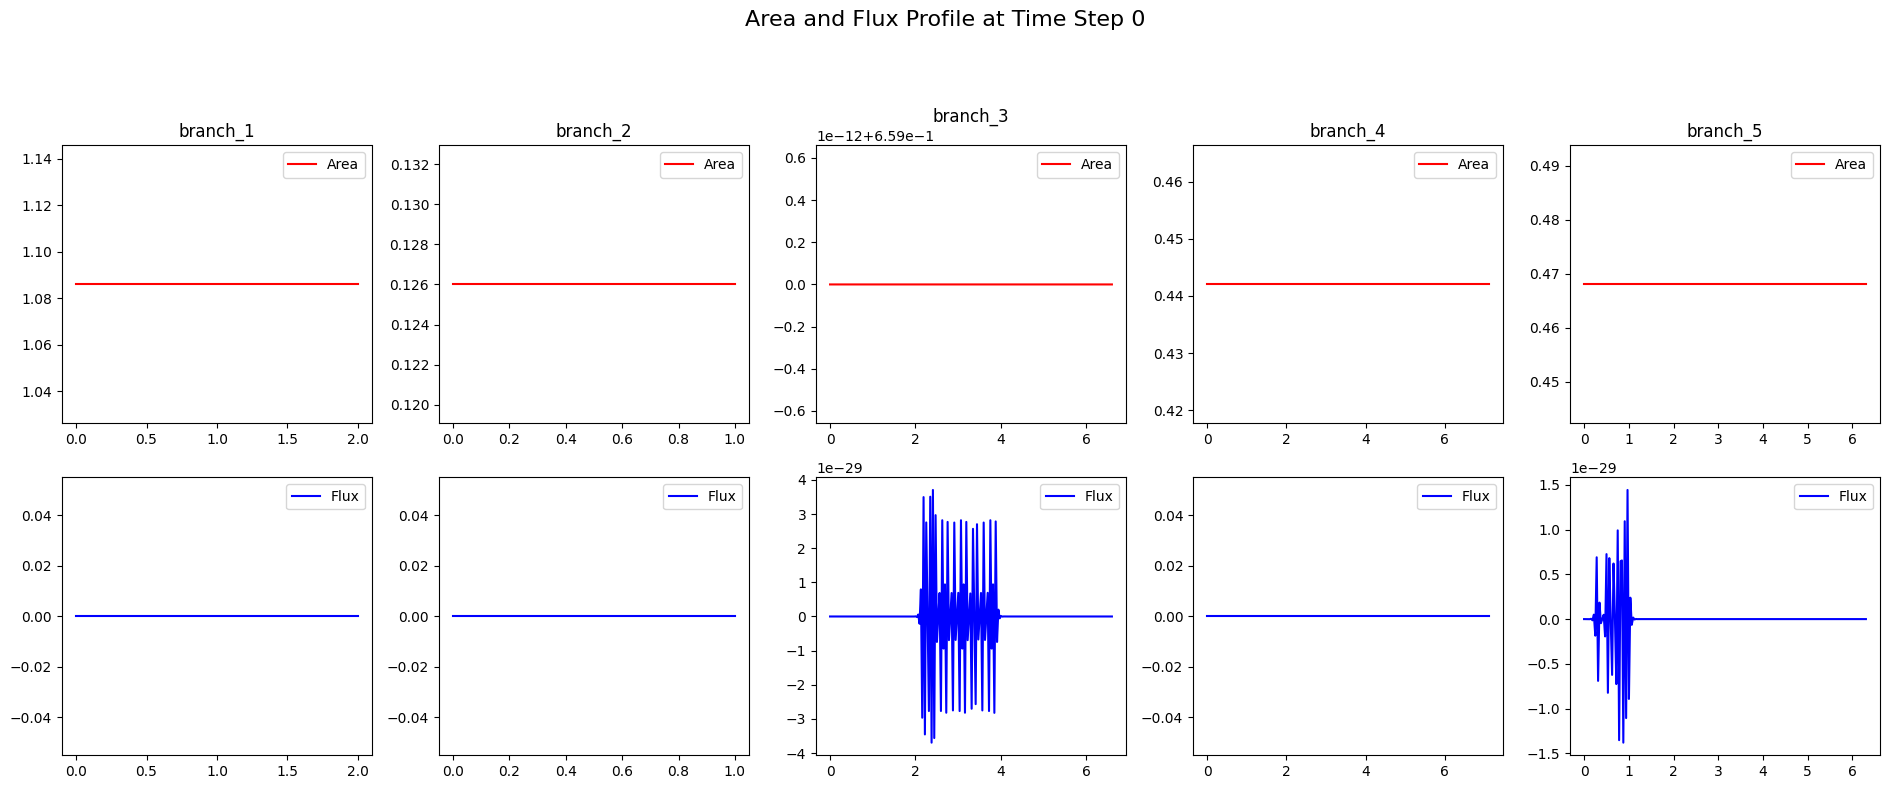

  0%|          | 6/50000 [00:07<16:24:39,  1.18s/it]


KeyboardInterrupt: 

In [ ]:
# Time stepping
t = 0

for n in tqdm(range(N_T)):
    # Solve the problem for each branch
    solve_local_branches(branches, branch_boundary_conditions)

    # Update time step
    t += dt

    # Update boundary conditions for inlets and outlets
    update_inlet_outlet_bcs(branches, t)

    # Handle branching points
    handle_branching_points(branches)

    #if n % 10 == 0:
      #plot_branches_combined(branches, n)

plot_branches_combined(branches, n)